In [1]:
import os
import gc
import re
import math
import pickle
import joblib
import warnings

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

from sklearn.model_selection import KFold, GroupKFold

import lightgbm as lgb

warnings.simplefilter("ignore")
pd.set_option("display.max_columns", None)

from IPython.core.display import display, HTML

display(HTML("<style>.container { width:96% !important; }</style>"))  # デフォルトは75%

In [2]:
import random as rn
import numpy as np


def set_seed(seed=0):
    os.environ["PYTHONHASHSEED"] = str(seed)

    rn.seed(seed)
    np.random.seed(seed)

In [3]:
from sklearn.metrics import mean_squared_log_error


def score(y, y_pred):
    RMSLE = np.sqrt(np.mean(((np.log(y + 1) - np.log(y_pred + 1)) ** 2)))
    # RMSLE = mean_squared_log_error(y, y_pred) ** 0.5
    return RMSLE

In [4]:
# https://stackoverflow.com/questions/61630331/early-stopping-for-lightgbm-not-working-when-rmsle-is-the-eval-metric
def rmsle_lgbm(y_pred, data):

    y_true = np.array(data.get_label())
    score = np.sqrt(np.mean(np.power(np.log1p(y_true) - np.log1p(y_pred), 2)))

    return 'rmsle', score, False

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt


def display_importances(
    importance_df, png_path=f"feature_importance.png",
):
    """feature_importance plot"""
    # importance_df.sort_values(by="importance", ascending=False).to_csv(
    #    f"feature_importance.csv"
    # )
    cols = (
        importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:100]
        .index
    )
    best_features = importance_df.loc[importance_df.feature.isin(cols)]
    plt.figure(figsize=(8, 15))
    sns.barplot(
        x="importance",
        y="feature",
        data=best_features.sort_values(by="importance", ascending=False),
    )
    plt.title(f"LightGBM (avg over folds)   {png_path}")
    plt.tight_layout()
    plt.savefig(png_path)

In [6]:
import category_encoders as ce


def count_encoder(
    X_train, Y_train, X_val, Y_val, target_col: str, cat_features=None, features=None
):
    """
    Count_Encoding: カテゴリ列をカウント値に変換する特徴量エンジニアリング（要はgroupby().size()の集計列追加のこと）
    ※カウント数が同じカテゴリは同じようなデータ傾向になる可能性がある
    https://www.kaggle.com/matleonard/categorical-encodings
    """
    X_train = pd.DataFrame(X_train, columns=features)
    Y_train = pd.DataFrame(Y_train, columns=[target_col])
    X_val = pd.DataFrame(X_val, columns=features)
    Y_val = pd.DataFrame(Y_val, columns=[target_col])

    train_df = X_train.join(Y_train)
    valid_df = X_val.join(Y_val)

    count_enc = ce.CountEncoder(cols=cat_features)

    # trainだけでfitすること(validationやtest含めるとリークする)
    count_enc.fit(train_df[cat_features])
    train_encoded = train_df.join(
        count_enc.transform(train_df[cat_features]).add_suffix("_count")
    )
    valid_encoded = valid_df.join(
        count_enc.transform(valid_df[cat_features]).add_suffix("_count")
    )

    features = train_encoded.drop(target_col, axis=1).columns.to_list()

    # return train_encoded, valid_encoded
    return (
        train_encoded.drop(target_col, axis=1),
        valid_encoded.drop(target_col, axis=1),
        features,
    )


def target_encoder(
    X_train, Y_train, X_val, Y_val, target_col: str, cat_features=None, features=None
):
    """
    Target_Encoding: カテゴリ列を目的変数の平均値に変換する特徴量エンジニアリング
    https://www.kaggle.com/matleonard/categorical-encodings
    """
    X_train = pd.DataFrame(X_train, columns=features)
    Y_train = pd.DataFrame(Y_train, columns=[target_col])
    X_val = pd.DataFrame(X_val, columns=features)
    Y_val = pd.DataFrame(Y_val, columns=[target_col])

    train_df = X_train.join(Y_train)
    valid_df = X_val.join(Y_val)

    target_enc = ce.TargetEncoder(cols=cat_features)

    # trainだけでfitすること(validationやtest含めるとリークする)
    target_enc.fit(train_df[cat_features], train_df[target_col])

    train_encoded = train_df.join(
        target_enc.transform(train_df[cat_features]).add_suffix("_target")
    )
    valid_encoded = valid_df.join(
        target_enc.transform(valid_df[cat_features]).add_suffix("_target")
    )

    features = train_encoded.drop(target_col, axis=1).columns.to_list()

    # return train_encoded, valid_encoded
    return (
        train_encoded.drop(target_col, axis=1),
        valid_encoded.drop(target_col, axis=1),
        features,
    )


def catboost_encoder(
    X_train, Y_train, X_val, Y_val, target_col: str, cat_features=None, features=None
):
    """
    CatBoost_Encoding: カテゴリ列を目的変数の1行前の行からのみに変換する特徴量エンジニアリング
    CatBoost使ったターゲットエンコーディング
    https://www.kaggle.com/matleonard/categorical-encodings
    """
    X_train = pd.DataFrame(X_train, columns=features)
    Y_train = pd.DataFrame(Y_train, columns=[target_col])
    X_val = pd.DataFrame(X_val, columns=features)
    Y_val = pd.DataFrame(Y_val, columns=[target_col])

    train_df = X_train.join(Y_train)
    valid_df = X_val.join(Y_val)

    cb_enc = ce.CatBoostEncoder(cols=cat_features, random_state=7)

    # trainだけでfitすること(validationやtest含めるとリークする)
    cb_enc.fit(train_df[cat_features], train_df[target_col])

    train_encoded = train_df.join(
        cb_enc.transform(train_df[cat_features]).add_suffix("_cb")
    )
    valid_encoded = valid_df.join(
        cb_enc.transform(valid_df[cat_features]).add_suffix("_cb")
    )

    features = train_encoded.drop(target_col, axis=1).columns.to_list()

    # return train_encoded, valid_encoded
    return (
        train_encoded.drop(target_col, axis=1),
        valid_encoded.drop(target_col, axis=1),
        features,
    )

# Data load

In [7]:
import pandas as pd

DATADIR = r"C:\Users\81908\jupyter_notebook\poetry_work\tfgpu\atmaCup_#8\data\atmacup08-dataset"
train = pd.read_csv(f"{DATADIR}/train.csv")
test = pd.read_csv(f"{DATADIR}/test.csv")
df = pd.concat([train, test], axis=0)

# 前処理

In [8]:
import numpy as np

# tbd(確認中)を欠損にする
df["User_Score"] = df["User_Score"].replace("tbd", np.nan)

In [9]:
# -1で補完
cate_cols = [
    "Name",
    "Platform",
    "Year_of_Release",
    "Genre",
    "Publisher",
    "Developer",
    "Rating",
]
for col in cate_cols:
    df[col].fillna(-1, inplace=True)

In [10]:
def impute_null_add_flag_col(
    df, strategy="mean", cols_with_missing=None, fill_value=None
):
    """欠損値を補間して欠損フラグ列を追加する
    fill_value はstrategy="constant"の時のみ有効になる補間する定数
    """
    from sklearn.impute import SimpleImputer

    df_plus = df.copy()

    for col in cols_with_missing:
        # 欠損フラグ列を追加
        df_plus[col + "_was_missing"] = df[col].isnull()
        df_plus[col + "_was_missing"] = df_plus[col + "_was_missing"].astype(int)
        # 欠損値を平均値で補間
        my_imputer = SimpleImputer(strategy=strategy, fill_value=fill_value)
        df_plus[col] = my_imputer.fit_transform(df[[col]])

    return df_plus


df = impute_null_add_flag_col(
    df, strategy="most_frequent", cols_with_missing=["User_Score"]
)  # 最頻値で補間

df = impute_null_add_flag_col(
    df, cols_with_missing=["Critic_Score", "Critic_Count", "User_Count",],
)  # 平均値で補間（数値列のみ）

In [11]:
# User_Scoreを数値列にする
df["User_Score"] = df["User_Score"].astype("float")

# User_Scoreを文字列にする
df["Year_of_Release"] = df["Year_of_Release"].astype("str")

In [12]:
# 続編を持つタイトルはid付ける
# https://www.guruguru.science/competitions/13/discussions/df06ef19-981d-4666-a0c0-22f62ee26640/
seriesies = [
    ".hack//",
    "12-Sai.",
    "18 Wheels of Steel: Extreme Trucker",
    "007: ",
    "FIFA World Cup",
    "7th Dragon",
    "A.C.E.: ",
    "Accel World:",
    "Super Robot Wars",
    "Ace Attorney Investigations",
    "Ace Combat",
    "Advance Wars",
    "Adventure Time: ",
    "Agatha Christie: ",
    "Age of Empires",
    "Age of Mythology",
    "Aikatsu",
    "Airline Tycoon",
    "AKB1/48: ",
    "Akiba's Trip",
    "All Kamen Rider: Rider Generation",
    "All Star Cheer Squad",
    "All-Star Baseball ",
    "Alone in the Dark",
    "Alvin and the Chipmunks",
    "American Chopper",
    "American Girl: ",
    "America's Army: ",
    "Arc the Lad",
    "Assassin's Creed",
    "BeatMania",
    "Bomberman",
    "Breath of Fire",
    "Broken Sword",
    "Call of ",
    "Chessmaster",
    "Chocobo",
    "Chibi Maruko-Chan",
    "Chibi-Robo! ",
    "Choro Q",
    "Chou-Kuukan Night Pro Yakyuu King",
    "Chrono",
    "Chuck E. Cheese's ",
    "Cities",
    "Colin McRae Rally",
    "College HoopsK",
    "LittleBigPlanet",
    "Littlest Pet Shop",
    "LocoRoco",
    "Looney Tunes",
    "Lord of the Rings",
    "Love Plus",
    "Luminous Arc",
    "MLB",
    "NFL",
    "NCAA",
    "NBA",
    "NASCAR",
    "NHL",
    "Namco Museum",
    "Naruto",
    "Need For Speed",
    "Marvel",
    "Mega Man",
    "Meitantei Conan",
    "Memories Off",
    "Metal Gear",
    "Metal Max",
    "Metal Saga",
    "Metal Slug",
    "Metroid",
    "Michael Jackson",
    "Micro Machines",
    "Microsoft Flight Simulator",
    "Minecraft",
    "Dynasty Warriors",
    "Durarara!!",
    "Duel Masters",
    "Dreamer Series:",
    "Dream C Club",
    "Dragon's Dogma",
    "Dragon Warrior",
    "Dragon Ball",
    "Devil May Cry",
    "Derby Stallion",
    "Dead or Alive",
    "Dance Dance Revolution",
    "Daito Giken Koushiki Pachi-Slot Simulator",
    "RPG Maker",
    "Puyo Puyo",
    "Pro Yaky? Spirits",
    "Pro Yakyuu Family Stadium",
    "Famista",
    "Far Cry",
    "Famicom Mini:",
    "Fallout",
    "FIFA Soccer",
    "F1",
    "F-Zero",
    "Fatal Fury",
    "Fatal Frame",
    "Fate/",
    "FlatOut",
    "Football Manager",
    "Football Manager Handheld",
    "Front Mission",
    "Galaxy Angel II",
    "Gallop Racer",
    "Gears of War",
    "God of War",
    "Godzilla",
    "GoldenEye",
    "Grand Theft Auto",
    "Grandia",
    "Guilty Gear",
    "Guitar Hero",
    "Gundam Battle",
    "Gundam Breaker",
    "Hakuouki",
    "Halo",
    "Harry Potter",
    "Harukanaru Toki no Naka de",
    "Harvest Moon",
    "Hello Kitty",
    "Hitman",
    "Imagine:",
    "Inazuma Eleven",
    "International Superstar Soccer",
    "Crash Bandicoot",
    "Kingdom Hearts",
    "Your Shape",
    "Yu-Gi-Oh",
    "Yuu Yuu Hakusho",
    "Zaidan Houjin Nippon Kanji Nouryoko Kentei Kyoukai Kounin: ",
    "Zenses: ",
    "Zero Escape: ",
    "Zero no Tsukaima: ",
    "ZhuZhu Pets",
    "Zoids" "Zoo Tycoon",
    "Zumba Fitness",
    "iCarly",
    "inFAMOUS",
    "thinkSMART",
    "uDraw Studio",
    "Disney",
    "Dragon Quest Monsters",
    "Dragon Quest",
    "Final Fantasy",
    "Mickey",
    "Sonic the Hedgehog",
    "Sonic",
    "Mario Party",
    "Mario Kart",
    "Mario",
    "Wii Sports",
    "Gran Turismo",
    "Pac-Man",
    "Uncharted",
    "Zelda",
    "The Last of Us",
    "Tekken",
    "Tetris",
    "Batman",
    "Professor Layton",
    "Splatoon",
    "Street Fighter",
    "Star Fox",
    "Ratchet & Clank",
    "Killzone",
    "Star Wars",
    "Metroid",
    "Pokemon",
    "LEGO",
    "Donkey Kong",
]

# df[df["Name"].str.contains("Mario").isnull()]  # 2行nNameなし行ある
df["series"] = -9999
for i, series in enumerate(seriesies):
    # print(i, series)
    df.loc[df["Name"].str.contains(series, na=False), "series"] = i
df["series"] = df["series"].astype("category")

In [13]:
# ラベルエンコディング
cate_cols = df.select_dtypes(include=["object", "category", "bool"]).columns.to_list()
for col in cate_cols:
    df[col], uni = pd.factorize(df[col])

In [14]:
train = df.iloc[: train.shape[0]]
test = df.iloc[train.shape[0] :].reset_index(drop=True)

# 目的変数
sales_cols = [
    "NA_Sales",
    "EU_Sales",
    "JP_Sales",
    "Other_Sales",
    "Global_Sales",
]

train_drop_sales = train.drop(sales_cols, axis=1)
test = test.drop(sales_cols, axis=1)

# FE

In [15]:
df = pd.concat([train_drop_sales, test], axis=0)

In [16]:
# User_Count 対数化
# https://www.guruguru.science/competitions/13/discussions/cbb736e9-f0f7-4847-811e-fe038e8ed0e8/
df["log_User_Count"] = np.log1p(df["User_Count"])

In [17]:
# 行単位で統計量とる
def add_num_row_agg(df_all, agg_num_cols):
    """行単位の統計量列追加
    agg_num_cols は数値列だけでないとエラー"""
    import warnings

    warnings.filterwarnings("ignore")

    df = df_all[agg_num_cols]
    cols = df.columns.to_list()
    cols = map(str, cols)  # 文字列にする
    col_name = "_".join(cols)

    df_all[f"row_{col_name}_sum"] = df.sum(axis=1)
    df_all[f"row_{col_name}_mean"] = df.mean(axis=1)
    df_all[f"row_{col_name}_std"] = df.std(axis=1)
    # df_all[f"row_{col_name}_skew"] = df.skew(axis=1)  # 歪度 Nan になるからやめる

    return df_all


df = add_num_row_agg(df, ["Critic_Score", "User_Score"])
df = add_num_row_agg(df, ["Critic_Count", "User_Count"])

In [18]:
import numpy as np
import pandas as pd


# A列でグループして集計したB列は意味がありそうと仮説たててから統計値列作ること
# 目的変数をキーにして集計するとリークしたターゲットエンコーディングになるため説明変数同士で行うこと
def grouping(df, cols, agg_dict, prefix=""):
    """特定のカラムについてgroup化された特徴量の作成を行う
    Args:
        df (pd.DataFrame): 特徴量作成のもととなるdataframe
        cols (str or list): group by処理のkeyとなるカラム (listで複数指定可能)
        agg_dict (dict): 特徴量作成を行いたいカラム/集計方法を指定するdictionary
        prefix (str): 集約後のカラムに付与するprefix name

    Returns:
        df (pd.DataFrame): 特定のカラムについてgroup化された特徴量群
    """
    group_df = df.groupby(cols).agg(agg_dict)
    group_df.columns = [prefix + c[0] + "_" + c[1] for c in list(group_df.columns)]
    group_df.reset_index(inplace=True)

    return group_df


class AggUtil:
    ############## カテゴリ列 vs. 数値列について ##############
    @staticmethod
    def percentile(n):
        """パーセンタイル"""

        def percentile_(x):
            return np.percentile(x, n)

        percentile_.__name__ = "percentile_%s" % n
        return percentile_

    @staticmethod
    def diff_percentile(n1, n2):
        """パーセンタイルの差"""

        def diff_percentile_(x):
            p1 = np.percentile(x, n1)
            p2 = np.percentile(x, n2)
            return p1 - p2

        diff_percentile_.__name__ = f"diff_percentile_{n1}-{n2}"
        return diff_percentile_

    @staticmethod
    def ratio_percentile(n1, n2):
        """パーセンタイルの比"""

        def ratio_percentile_(x):
            p1 = np.percentile(x, n1)
            p2 = np.percentile(x, n2)
            return p1 / p2

        ratio_percentile_.__name__ = f"ratio_percentile_{n1}-{n2}"
        return ratio_percentile_

    @staticmethod
    def mean_var():
        """平均分散"""

        def mean_var_(x):
            x = x.dropna()
            return np.std(x) / np.mean(x)

        mean_var_.__name__ = f"mean_var"
        return mean_var_

    @staticmethod
    def diff_mean():
        """平均との差の中央値(aggは集計値でないとエラーになるから中央値をとる)"""

        def diff_mean_(x):
            x = x.dropna()
            return np.median(x - np.mean(x))

        diff_mean_.__name__ = f"diff_mean"
        return diff_mean_

    @staticmethod
    def ratio_mean():
        """平均との比の中央値(aggは一意な値でないとエラーになるから中央値をとる)"""

        def ratio_mean_(x):
            x = x.dropna()
            return np.median(x / np.mean(x))

        ratio_mean_.__name__ = f"ratio_mean"
        return ratio_mean_

    @staticmethod
    def hl_ratio():
        """平均より高いサンプル数と低いサンプル数の比率"""

        def hl_ratio_(x):
            x = x.dropna()
            n_high = x[x >= np.mean(x)].shape[0]
            n_low = x[x < np.mean(x)].shape[0]
            if n_low == 0:
                return 1.0
            else:
                return n_high / n_low

        hl_ratio_.__name__ = f"hl_ratio"
        return hl_ratio_

    @staticmethod
    def ratio_range():
        """最大/最小"""

        def ratio_range_(x):
            x = x.dropna()
            if np.min(x) == 0:
                return 1.0
            else:
                return np.max(x) / np.min(x)

        ratio_range_.__name__ = f"ratio_range"
        return ratio_range_

    @staticmethod
    def beyond1std():
        """1stdを超える比率"""

        def beyond1std_(x):
            x = x.dropna()
            return x[np.abs(x) > np.abs(np.std(x))].shape[0] / x.shape[0]

        beyond1std_.__name__ = "beyond1std"
        return beyond1std_

    @staticmethod
    def zscore():
        """Zスコアの中央値(aggは一意な値でないとエラーになるから中央値をとる)"""

        def zscore_(x):
            x = x.dropna()
            return np.median((x - np.mean(x)) / np.std(x))

        zscore_.__name__ = "zscore"
        return zscore_

    ######################################################

    ############## カテゴリ列 vs. カテゴリ列について ##############
    @staticmethod
    def freq_entropy():
        """出現頻度のエントロピー"""
        from scipy.stats import entropy

        def freq_entropy_(x):
            return entropy(x.value_counts().values)

        freq_entropy_.__name__ = "freq_entropy"
        return freq_entropy_

    @staticmethod
    def freq1name():
        """最も頻繁に出現するカテゴリの数"""

        def freq1name_(x):
            return x.value_counts().sort_values(ascending=False)[0]

        freq1name_.__name__ = "freq1name"
        return freq1name_

    @staticmethod
    def freq1ratio():
        """最も頻繁に出現するカテゴリ/グループの数"""

        def freq1ratio_(x):
            frq = x.value_counts().sort_values(ascending=False)
            return frq[0] / frq.shape[0]

        freq1ratio_.__name__ = "freq1ratio"
        return freq1ratio_

    #########################################################


# 集計する数値列指定
value_agg = {
    "User_Count": [
        "max",
        "min",
        "mean",
        "std",  # 標準偏差
        "skew",  # 歪度
        pd.DataFrame.kurt,  # 尖度
    ],
    "Critic_Count": [
        "max",
        "min",
        "mean",
        "std",  # 標準偏差
        "skew",  # 歪度
        pd.DataFrame.kurt,  # 尖度
    ],
    "User_Score": [
        "max",
        "min",
        "mean",
        "std",  # 標準偏差
        "skew",  # 歪度
        pd.DataFrame.kurt,  # 尖度
    ],
    "Critic_Score": [
        "max",
        "min",
        "mean",
        "std",  # 標準偏差
        "skew",  # 歪度
        pd.DataFrame.kurt,  # 尖度
    ],
}
# グループ化するカテゴリ列でループ
for key in ["Platform", "Genre", "Publisher", "Developer", "Rating"]:
    feature_df = grouping(df, key, value_agg, prefix=key + "_")
    df = pd.merge(df, feature_df, how="left", on=key)

In [19]:
df["Critic_Score_*_Critic_Count"] = df["Critic_Score"] * df["Critic_Count"]
df["User_Score_*_User_Count"] = df["User_Score"] * df["User_Count"]
df["Critic_Score_*_User_Score"] = df["Critic_Score"] * df["User_Score"]
df["Critic_Count_*_User_Count"] = df["Critic_Count"] * df["User_Count"]
df["Critic_Count_+_User_Count"] = df["Critic_Count"] + df["User_Count"]
df["Critic_Count_-_User_Count"] = df["Critic_Count"] - df["User_Count"]
df["Critic_Count_/_all_Count"] = df["Critic_Count"] / df["Critic_Count_+_User_Count"]

In [20]:
# KMeansでクラスタリングした列追加

from sklearn.cluster import KMeans


def fe_cluster(df, kind, features, n_clusters=100, SEED=42, is_dummies=False):
    df_ = df[features].copy()
    kmeans_cells = KMeans(n_clusters=n_clusters, random_state=SEED).fit(df_)
    df[f"clusters_{kind}"] = kmeans_cells.predict(df_.values)
    df = pd.get_dummies(df, columns=[f"clusters_{kind}"]) if is_dummies else df

    return df


df = fe_cluster(
    df,
    kind="cate_cols",
    features=["Name", "Genre", "Publisher", "Developer", "Rating"],
    n_clusters=3000,
)
df = fe_cluster(
    df,
    kind="Score_Count",
    features=["Critic_Score", "User_Score", "Critic_Count", "User_Count"],
    n_clusters=300,
)

In [21]:
train_drop_sales = df.iloc[: train.shape[0]]
test = df.iloc[train.shape[0] :].reset_index(drop=True)

In [22]:
pd.concat([train_drop_sales, train[sales_cols]], axis=1).to_csv("train_fe.csv", index=False)
test.to_csv("test_fe.csv", index=False)

In [23]:
train_drop_sales

,Name,Platform,Year_of_Release,Genre,Publisher,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,User_Score_was_missing,Critic_Score_was_missing,Critic_Count_was_missing,User_Count_was_missing,series,log_User_Count,row_Critic_Score_User_Score_sum,row_Critic_Score_User_Score_mean,row_Critic_Score_User_Score_std,row_Critic_Count_User_Count_sum,row_Critic_Count_User_Count_mean,row_Critic_Count_User_Count_std,Platform_User_Count_max,Platform_User_Count_min,Platform_User_Count_mean,Platform_User_Count_std,Platform_User_Count_skew,Platform_User_Count_kurt,Platform_Critic_Count_max,Platform_Critic_Count_min,Platform_Critic_Count_mean,Platform_Critic_Count_std,Platform_Critic_Count_skew,Platform_Critic_Count_kurt,Platform_User_Score_max,Platform_User_Score_min,Platform_User_Score_mean,Platform_User_Score_std,Platform_User_Score_skew,Platform_User_Score_kurt,Platform_Critic_Score_max,Platform_Critic_Score_min,Platform_Critic_Score_mean,Platform_Critic_Score_std,Platform_Critic_Score_skew,Platform_Critic_Score_kurt,Genre_User_Count_max,Genre_User_Count_min,Genre_User_Count_mean,Genre_User_Count_std,Genre_User_Count_skew,Genre_User_Count_kurt,Genre_Critic_Count_max,Genre_Critic_Count_min,Genre_Critic_Count_mean,Genre_Critic_Count_std,Genre_Critic_Count_skew,Genre_Critic_Count_kurt,Genre_User_Score_max,Genre_User_Score_min,Genre_User_Score_mean,Genre_User_Score_std,Genre_User_Score_skew,Genre_User_Score_kurt,Genre_Critic_Score_max,Genre_Critic_Score_min,Genre_Critic_Score_mean,Genre_Critic_Score_std,Genre_Critic_Score_skew,Genre_Critic_Score_kurt,Publisher_User_Count_max,Publisher_User_Count_min,Publisher_User_Count_mean,Publisher_User_Count_std,Publisher_User_Count_skew,Publisher_User_Count_kurt,Publisher_Critic_Count_max,Publisher_Critic_Count_min,Publisher_Critic_Count_mean,Publisher_Critic_Count_std,Publisher_Critic_Count_skew,Publisher_Critic_Count_kurt,Publisher_User_Score_max,Publisher_User_Score_min,Publisher_User_Score_mean,Publisher_User_Score_std,Publisher_User_Score_skew,Publisher_User_Score_kurt,Publisher_Critic_Score_max,Publisher_Critic_Score_min,Publisher_Critic_Score_mean,Publisher_Critic_Score_std,Publisher_Critic_Score_skew,Publisher_Critic_Score_kurt,Developer_User_Count_max,Developer_User_Count_min,Developer_User_Count_mean,Developer_User_Count_std,Developer_User_Count_skew,Developer_User_Count_kurt,Developer_Critic_Count_max,Developer_Critic_Count_min,Developer_Critic_Count_mean,Developer_Critic_Count_std,Developer_Critic_Count_skew,Developer_Critic_Count_kurt,Developer_User_Score_max,Developer_User_Score_min,Developer_User_Score_mean,Developer_User_Score_std,Developer_User_Score_skew,Developer_User_Score_kurt,Developer_Critic_Score_max,Developer_Critic_Score_min,Developer_Critic_Score_mean,Developer_Critic_Score_std,Developer_Critic_Score_skew,Developer_Critic_Score_kurt,Rating_User_Count_max,Rating_User_Count_min,Rating_User_Count_mean,Rating_User_Count_std,Rating_User_Count_skew,Rating_User_Count_kurt,Rating_Critic_Count_max,Rating_Critic_Count_min,Rating_Critic_Count_mean,Rating_Critic_Count_std,Rating_Critic_Count_skew,Rating_Critic_Count_kurt,Rating_User_Score_max,Rating_User_Score_min,Rating_User_Score_mean,Rating_User_Score_std,Rating_User_Score_skew,Rating_User_Score_kurt,Rating_Critic_Score_max,Rating_Critic_Score_min,Rating_Critic_Score_mean,Rating_Critic_Score_std,Rating_Critic_Score_skew,Rating_Critic_Score_kurt,Critic_Score_*_Critic_Count,User_Score_*_User_Count,Critic_Score_*_User_Score,Critic_Count_*_User_Count,Critic_Count_+_User_Count,Critic_Count_-_User_Count,Critic_Count_/_all_Count,clusters_cate_cols,clusters_Score_Count
0,0,0,0,0,0,74.000000,17.000000,7.9,22.000000,0,0,0,0,0,0,0,3.135494,81.900000,40.950000,46.739758,39.000000,19.500000,3.535534,2147.000000,4.000000,115.942220,134.680370,8.680930,112.286301,87.000000,4.000000,24.094851,11.556586,1.281734,5.078568,9.3,0.2,7.351439,1.247140,-2.681698,8.297436,97.000000,19.000000,66.244882,10.359427,-1.509346,3.764847,8003.0,4.0,176.

In [24]:
test

,Name,Platform,Year_of_Release,Genre,Publisher,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,User_Score_was_missing,Critic_Score_was_missing,Critic_Count_was_missing,User_Count_was_missing,series,log_User_Count,row_Critic_Score_User_Score_sum,row_Critic_Score_User_Score_mean,row_Critic_Score_User_Score_std,row_Critic_Count_User_Count_sum,row_Critic_Count_User_Count_mean,row_Critic_Count_User_Count_std,Platform_User_Count_max,Platform_User_Count_min,Platform_User_Count_mean,Platform_User_Count_std,Platform_User_Count_skew,Platform_User_Count_kurt,Platform_Critic_Count_max,Platform_Critic_Count_min,Platform_Critic_Count_mean,Platform_Critic_Count_std,Platform_Critic_Count_skew,Platform_Critic_Count_kurt,Platform_User_Score_max,Platform_User_Score_min,Platform_User_Score_mean,Platform_User_Score_std,Platform_User_Score_skew,Platform_User_Score_kurt,Platform_Critic_Score_max,Platform_Critic_Score_min,Platform_Critic_Score_mean,Platform_Critic_Score_std,Platform_Critic_Score_skew,Platform_Critic_Score_kurt,Genre_User_Count_max,Genre_User_Count_min,Genre_User_Count_mean,Genre_User_Count_std,Genre_User_Count_skew,Genre_User_Count_kurt,Genre_Critic_Count_max,Genre_Critic_Count_min,Genre_Critic_Count_mean,Genre_Critic_Count_std,Genre_Critic_Count_skew,Genre_Critic_Count_kurt,Genre_User_Score_max,Genre_User_Score_min,Genre_User_Score_mean,Genre_User_Score_std,Genre_User_Score_skew,Genre_User_Score_kurt,Genre_Critic_Score_max,Genre_Critic_Score_min,Genre_Critic_Score_mean,Genre_Critic_Score_std,Genre_Critic_Score_skew,Genre_Critic_Score_kurt,Publisher_User_Count_max,Publisher_User_Count_min,Publisher_User_Count_mean,Publisher_User_Count_std,Publisher_User_Count_skew,Publisher_User_Count_kurt,Publisher_Critic_Count_max,Publisher_Critic_Count_min,Publisher_Critic_Count_mean,Publisher_Critic_Count_std,Publisher_Critic_Count_skew,Publisher_Critic_Count_kurt,Publisher_User_Score_max,Publisher_User_Score_min,Publisher_User_Score_mean,Publisher_User_Score_std,Publisher_User_Score_skew,Publisher_User_Score_kurt,Publisher_Critic_Score_max,Publisher_Critic_Score_min,Publisher_Critic_Score_mean,Publisher_Critic_Score_std,Publisher_Critic_Score_skew,Publisher_Critic_Score_kurt,Developer_User_Count_max,Developer_User_Count_min,Developer_User_Count_mean,Developer_User_Count_std,Developer_User_Count_skew,Developer_User_Count_kurt,Developer_Critic_Count_max,Developer_Critic_Count_min,Developer_Critic_Count_mean,Developer_Critic_Count_std,Developer_Critic_Count_skew,Developer_Critic_Count_kurt,Developer_User_Score_max,Developer_User_Score_min,Developer_User_Score_mean,Developer_User_Score_std,Developer_User_Score_skew,Developer_User_Score_kurt,Developer_Critic_Score_max,Developer_Critic_Score_min,Developer_Critic_Score_mean,Developer_Critic_Score_std,Developer_Critic_Score_skew,Developer_Critic_Score_kurt,Rating_User_Count_max,Rating_User_Count_min,Rating_User_Count_mean,Rating_User_Count_std,Rating_User_Count_skew,Rating_User_Count_kurt,Rating_Critic_Count_max,Rating_Critic_Count_min,Rating_Critic_Count_mean,Rating_Critic_Count_std,Rating_Critic_Count_skew,Rating_Critic_Count_kurt,Rating_User_Score_max,Rating_User_Score_min,Rating_User_Score_mean,Rating_User_Score_std,Rating_User_Score_skew,Rating_User_Score_kurt,Rating_Critic_Score_max,Rating_Critic_Score_min,Rating_Critic_Score_mean,Rating_Critic_Score_std,Rating_Critic_Score_skew,Rating_Critic_Score_kurt,Critic_Score_*_Critic_Count,User_Score_*_User_Count,Critic_Score_*_User_Score,Critic_Count_*_User_Count,Critic_Count_+_User_Count,Critic_Count_-_User_Count,Critic_Count_/_all_Count,clusters_cate_cols,clusters_Score_Count
0,6231,14,0,0,295,84.000000,23.000000,8.0,19.000000,1012,2,0,0,0,0,90,2.995732,92.000000,46.000000,53.740115,42.000000,21.000000,2.828427,1283.0,4.0,64.110095,90.445403,5.811620,70.390878,91.000000,4.0,26.369807,14.117421,1.243040,2.408514,9.3,0.5,7.587015,1.280184,-2.167418,5.901917,97.0,19.0,69.752185,13.191776,-0.808820,0.939315,8003.0,4.0,176.706842,399.969165,

# params

In [25]:
n_seeds = 5
#n_seeds = 1
n_splits = 5
shuffle = True

## cv: 1.0830(LB: -), psude cv: 1.0768(LB: 0.9899)
# params = {
#    "boosting_type": "gbdt",
#    "verbosity": -1,
#    #"objective": "root_mean_squared_error",  # RMSE
#    'objective': 'regression',
#    'metric': 'custom',  # RMSLE
#    "learning_rate": 0.01,
#    "feature_fraction": 0.5,
#    "lambda_l1": 8.647619848158392,
#    "lambda_l2": 1.0881077642285376e-09,
#    "max_depth": 7,
#    "min_data_in_leaf": 1,
#    "num_leaves": 111,
#    "reg_sqrt": True,
# }
# cv: 1.0356(LB: -), psude cv: 1.0362(LB: 0.9719)
params = {
    "boosting_type": "gbdt",
    "verbosity": -1,
    # "objective": "root_mean_squared_error",  # RMSE
    "objective": "regression",
    "metric": "custom",  # RMSLE
    "learning_rate": 0.01,
    "feature_fraction": 0.1,
    "lambda_l1": 0.0003803817551544506,
    "lambda_l2": 0.000598849965523465,
    "max_depth": 5,
    "min_data_in_leaf": 11,
    "num_leaves": 29,
    "reg_sqrt": True,
}

num_boost_round = 20000
verbose_eval = num_boost_round // 10
early_stopping_rounds = 100

# is_y_log = True
is_y_log = False

#DEBUG = True
DEBUG = False
if DEBUG:
    params["learning_rate"] = 0.1
    n_seeds = 2
    n_splits = 2
    num_boost_round = 100
    verbose_eval = 50
    early_stopping_rounds = verbose_eval

In [26]:
# group_col = "Name"
group_col = "Publisher"  # https://www.guruguru.science/competitions/13/discussions/42fc473d-4450-4cfc-b924-0a5d61fd0ca7/

# GroupKFold
group = train_drop_sales[group_col].copy()  

# seed値が指定できるGroupKFold  https://www.guruguru.science/competitions/13/discussions/cc7167cb-3627-448a-b9eb-7afcd29fd122/
group = train_drop_sales[group_col].copy()
group_uni = train_drop_sales[group_col].copy().unique()

In [27]:
# test setとあまり被りのない特徴量は除外  https://www.guruguru.science/competitions/13/discussions/df06ef19-981d-4666-a0c0-22f62ee26640/

inbalance = ["Publisher", "Developer", "Name"]
train_drop_sales = train_drop_sales.drop(inbalance, axis=1)
test = test.drop(inbalance, axis=1)

cate_cols = list(set(cate_cols) - set(inbalance))
print("cate_cols:", cate_cols)

cate_cols: ['series', 'Platform', 'Year_of_Release', 'Rating', 'Genre']


In [28]:
features = test.columns.to_list()

global_target_col = "Global_Sales"
target_cols = [
    "NA_Sales",
    "EU_Sales",
    "JP_Sales",
    "Other_Sales",
]

X = train_drop_sales[features].copy()
Y = train[target_cols].copy()
Y_global = train[global_target_col].copy()

train_size, n_features = X.shape

_, n_classes = Y.shape

# lgbm

In [29]:
def fit_lgbm(params, X_tr, X_va, y_tr, y_va, seed):
    params["seed"] = seed

    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_va, y_va, reference=lgb_train)

    model = lgb.train(
        params,
        lgb_train,
        valid_sets=[lgb_train, lgb_eval],
        verbose_eval=verbose_eval,
        num_boost_round=num_boost_round,
        early_stopping_rounds=early_stopping_rounds,
        feval=rmsle_lgbm,
    )
    
    imp = np.array(model.feature_importance(importance_type="gain"))
    
    return model, imp

In [30]:
def fit_model(Y, features_imp=None, out_pkl="Y_pred.pkl"): 
    
    # Y 対数化
    if is_y_log:
        Y = Y.apply(lambda x: np.log1p(x))
    
    f_importance = {col: None for col in Y.columns}
    Y_pred = np.zeros((train_size, n_classes))
    Y_pred = pd.DataFrame(Y_pred, columns=Y.columns, index=Y.index)

    for i in tqdm(range(n_seeds)):
        set_seed(seed=i)

        cv = KFold(n_splits=n_splits, random_state=i, shuffle=shuffle)
        #cv_split = cv.split(X, Y)  # KFold
        cv_split = cv.split(group_uni)  # GroupRandomKFold
        #cv = GroupKFold(n_splits=n_splits)
        #cv_split = cv.split(X, Y, group)

        for j, (trn_idx, val_idx) in enumerate(cv_split):        
            print(f"\n------------ fold:{j} ------------")
            # GroupRandomKFold
            tr_groups, va_groups = group_uni[trn_idx], group_uni[val_idx]
            trn_idx = group[group.isin(tr_groups)].index
            val_idx = group[group.isin(va_groups)].index
            print("len(trn_idx), len(val_idx):", len(trn_idx), len(val_idx))

            X_train, X_val = X.iloc[trn_idx], X.iloc[val_idx]
            Y_train_targets, Y_val_targets = Y.iloc[trn_idx], Y.iloc[val_idx]

            for tar, tar_col in enumerate(Y.columns):
                print(f"\n------------ target:{tar_col} ------------")
                Y_train, Y_val = Y_train_targets.values[:, tar], Y_val_targets.values[:, tar]

                X_train_enc, X_val_enc, features_enc = X_train.copy(), X_val.copy(), features.copy()
                # count_encoder はやめとく。存在しないNameやPublisherなnanaになるので
                # X_train_enc, X_val_enc, features_enc = count_encoder(X_train_enc, Y_train, X_val_enc, Y_val, target_col=tar_col, cat_features=cate_cols, features=features_enc)
                X_train_enc, X_val_enc, features_enc = target_encoder(X_train_enc, Y_train, X_val_enc, Y_val, target_col=tar_col, cat_features=cate_cols, features=features_enc,)
                # X_train_enc, X_val_enc, features_enc = catboost_encoder(X_train_enc, Y_train, X_val_enc, Y_val, target_col=tar_col, cat_features=cate_cols, features=features_enc)

                # importance 上位100位までの特徴量だけにする
                if features_imp is not None:
                    X_train_enc, X_val_enc = X_train_enc[features_imp], X_val_enc[features_imp]

                model, imp = fit_lgbm(params, X_train_enc, X_val_enc, Y_train, Y_val, i)
                
                va_pred = model.predict(X_val_enc, num_iteration=model.best_iteration)
                
                # Y_pred の対数化解除
                if is_y_log:
                    va_pred = np.expm1(va_pred)
                
                va_pred = np.where(va_pred<0, 0, va_pred)
                
                Y_pred[tar_col][val_idx] += va_pred / n_seeds

                if f_importance[tar_col] is None:
                    f_importance[tar_col] = imp / (n_seeds * n_splits)
                else:
                    f_importance[tar_col] += imp / (n_seeds * n_splits)

                joblib.dump(model, f"model_seed_{i}_fold_{j}_{tar_col}.jlb", compress=True)

    with open(out_pkl, "wb") as f:
        pickle.dump(Y_pred, f)

    return Y_pred, features_enc, f_importance, model

In [31]:
%%time
Y_pred, features_enc, f_importance, model = fit_model(Y)


------------ fold:0 ------------
len(trn_idx), len(val_idx): 6174 2185

------------ target:NA_Sales ------------
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1244]	training's rmsle: 0.745781	valid_1's rmsle: 1.42205

------------ target:EU_Sales ------------
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[778]	training's rmsle: 0.759885	valid_1's rmsle: 1.43517

------------ target:JP_Sales ------------
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1239]	training's rmsle: 0.564069	valid_1's rmsle: 1.3608

------------ target:Other_Sales ------------
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1054]	training's rmsle: 0.496431	valid_1's rmsle: 0.97531

------------ fold:1 ------------
len(trn_idx), len(val_idx): 7540 819

------------ target:NA_Sales ------------
Training until va

[2000]	training's rmsle: 0.694016	valid_1's rmsle: 1.35181
Early stopping, best iteration is:
[2285]	training's rmsle: 0.677579	valid_1's rmsle: 1.34891

------------ target:EU_Sales ------------
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1559]	training's rmsle: 0.643317	valid_1's rmsle: 1.30194

------------ target:JP_Sales ------------
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[818]	training's rmsle: 0.559777	valid_1's rmsle: 1.26246

------------ target:Other_Sales ------------
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1173]	training's rmsle: 0.472781	valid_1's rmsle: 0.901428

------------ fold:0 ------------
len(trn_idx), len(val_idx): 6216 2143

------------ target:NA_Sales ------------
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1687]	training's rmsle: nan	valid_

Early stopping, best iteration is:
[189]	training's rmsle: 1.01739	valid_1's rmsle: 1.25768

------------ target:JP_Sales ------------
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[585]	training's rmsle: 0.724528	valid_1's rmsle: 1.02627

------------ target:Other_Sales ------------
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1315]	training's rmsle: 0.489457	valid_1's rmsle: 0.814795

------------ fold:4 ------------
len(trn_idx), len(val_idx): 6493 1866

------------ target:NA_Sales ------------
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[751]	training's rmsle: 0.870153	valid_1's rmsle: 1.38125

------------ target:EU_Sales ------------
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[707]	training's rmsle: 0.844258	valid_1's rmsle: 1.34445

------------ target:JP_Sales ---------

In [32]:
score(Y, Y_pred)

NA_Sales       1.215940
EU_Sales       1.165133
JP_Sales       1.012263
Other_Sales    0.771103
dtype: float64

In [33]:
score(Y_global, Y_pred.sum(axis=1))

1.0346706263369825

,NA_Sales,EU_Sales,JP_Sales,Other_Sales
Platform,41662.684688,21097.048238,14050.992618,7329.777185
Year_of_Release,88267.764832,27516.495456,30875.340390,6005.301098
Genre,11198.615989,6008.663471,5262.203082,1140.558440
Critic_Score,56985.224313,20205.703447,8006.974372,6836.889127
Critic_Count,73501.069344,47883.396682,12185.189456,20636.749662
...,...,...,...,...
series_target,175942.369382,92832.777318,68379.263732,21284.891769
Platform_target,82988.253646,25089.892919,68961.262368,12515.212389
Year_of_Release_target,64500.223030,18264.978912,38704.119610,4631.677360
Rating_target,6305.871648,1856.417623,1793.212643,657.654030


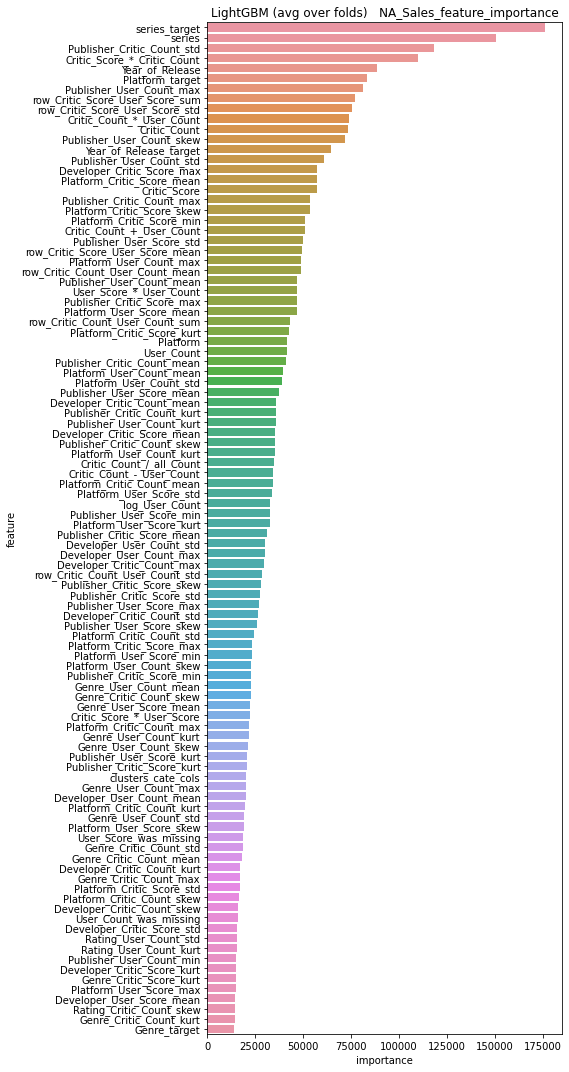

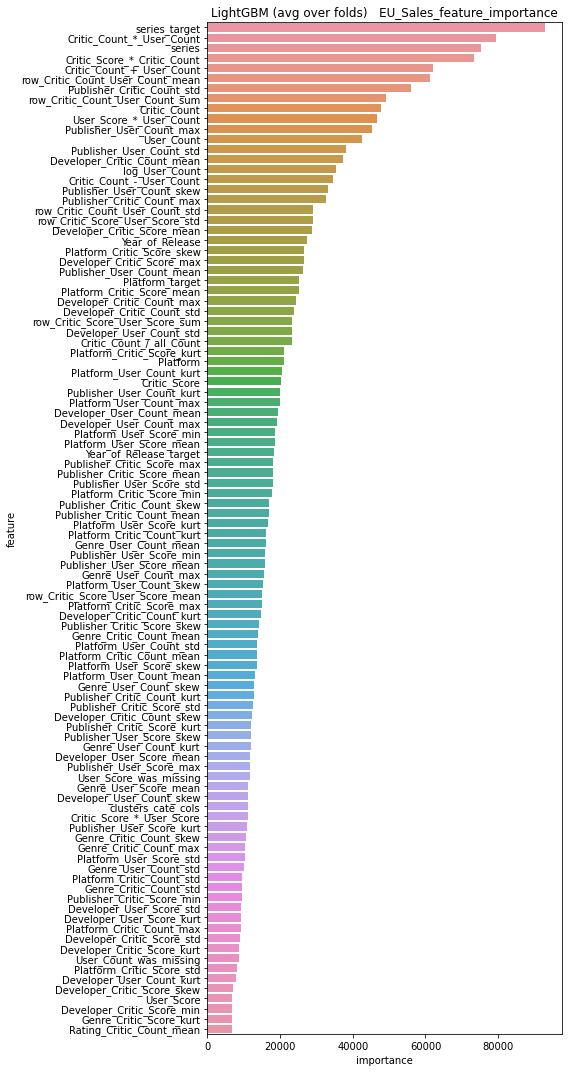

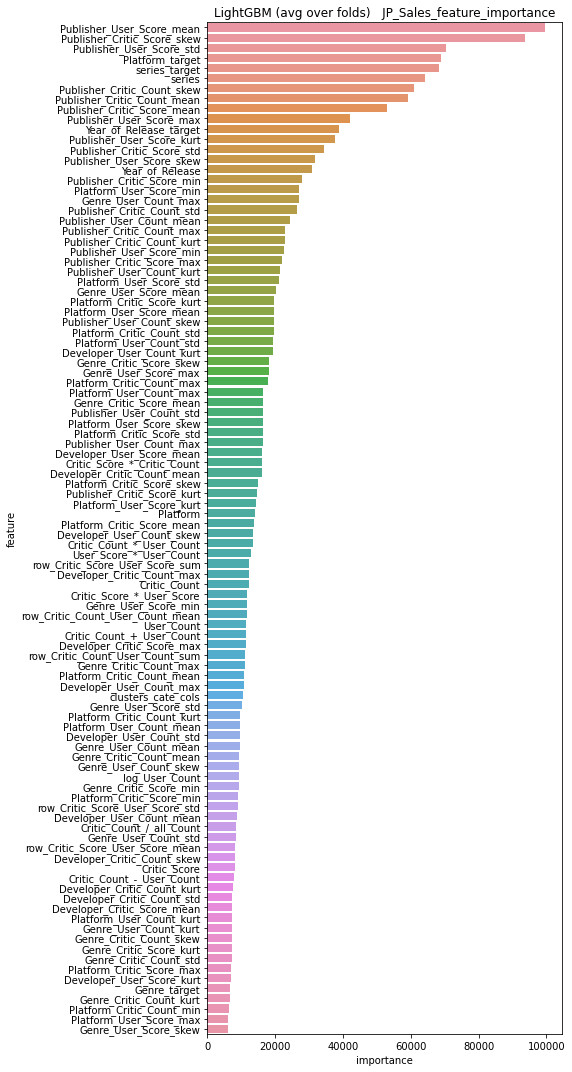

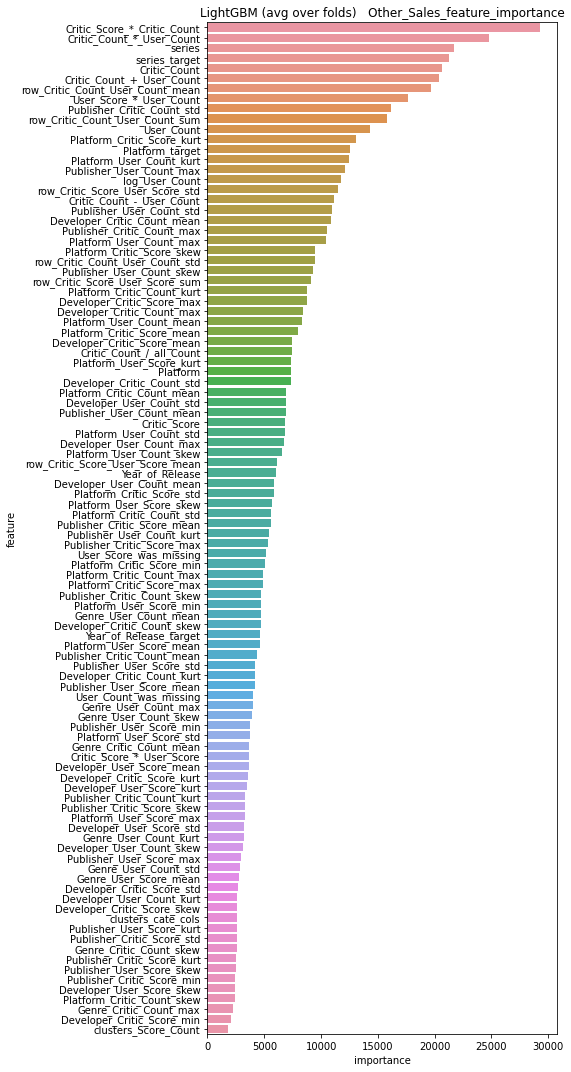

In [34]:
def _importance(features, n_features):
    df_f_imps = np.zeros((n_features, len(f_importance)))
    df_f_imps = pd.DataFrame(df_f_imps, columns=Y.columns, index=model.feature_name())

    for _, tar_col in enumerate(Y.columns):
        df_importance = pd.DataFrame(
            {"feature": model.feature_name(), "importance": f_importance[tar_col]}
        )
        display_importances(df_importance, png_path=f"{tar_col}_feature_importance")

        df_f_imps[tar_col] = f_importance[tar_col]

    df_f_imps.to_csv("feature_importance.csv")
    return df_f_imps


df_f_imps = _importance(features_enc, len(features_enc))
df_f_imps

# oof

In [35]:
path = r"Y_pred.pkl"
with open(path, "rb") as f:
    Y_pred = pickle.load(f)
Y_pred

,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,47.494261,23.996019,0.121267,7.297962
1,43.416376,27.340339,0.158038,8.171437
2,24.730557,15.646441,0.056730,7.286807
3,24.860107,4.380534,0.166650,0.344630
4,47.935715,23.043062,0.063193,7.748818
...,...,...,...,...
8354,0.379093,7.537062,0.079665,1.064307
8355,1.080311,2.410994,0.000000,0.184598
8356,0.000890,0.098794,4.216672,0.006146
8357,8.705742,5.572322,3.438031,2.336904


# predict test

In [36]:
def predict_test(out_csv="submission.csv", features_imp=None):
    
    X_test = test.copy()
    Y_test_pred = pd.Series(np.zeros((test.shape[0])))

    for i in range(n_seeds):
        for j in range(n_splits):
            for tar_col in Y.columns:
                model_path = f"model_seed_{i}_fold_{j}_{tar_col}.jlb"
                model = joblib.load(model_path)

                X_enc, X_test_enc, features_enc = X.copy(), X_test.copy(), features.copy()
                # count_encoder はやめとく。存在しないNameやPublisherなnanaになるので
                # X_enc, X_test_enc, features_enc = count_encoder(X_enc, Y[tar_col], X_test_enc, Y_test_pred, target_col=tar_col, cat_features=cate_cols, features=features_enc)
                X_enc, X_test_enc, features_enc = target_encoder(X_enc, Y[tar_col], X_test_enc, Y_test_pred, target_col=tar_col, cat_features=cate_cols, features=features_enc,)
                # X_enc, X_test_enc, features_enc = catboost_encoder(X_enc, Y[tar_col], X_test_enc, Y_test_pred, target_col=tar_col, cat_features=cate_cols, features=features_enc)

                # importance 上位100位までの特徴量だけにする
                if features_imp is not None:
                    X_test_enc = X_test_enc[features_imp]

                t_pred = model.predict(X_test_enc)
                    
                # Y_pred の対数化解除
                if is_y_log:
                    t_pred = np.expm1(t_pred)
                
                t_pred = np.where(t_pred<0, 0, t_pred)

                Y_test_pred += t_pred / (n_seeds * n_splits)

    print(Y_test_pred.shape)

    submission = pd.read_csv(f"{DATADIR}/atmaCup8_sample-submission.csv")
    submission["Global_Sales"] = Y_test_pred
    submission.to_csv(out_csv, index=False)
    return submission

In [37]:
predict_test()

(8360,)


,Global_Sales
0,32.523324
1,108.097302
2,68.313952
3,61.870089
4,55.115037
...,...
8355,8.664555
8356,12.783526
8357,4.295228
8358,4.649167


# psude_label

In [38]:
# 疑似ラベル作成
X_test = test.copy()
Y_test_pred = np.zeros((test.shape[0], n_classes))
Y_test_pred = pd.DataFrame(Y_test_pred, columns=target_cols, index=test.index)

for i in range(n_seeds):
    for j in range(n_splits):
        for tar_col in Y.columns:
            model_path = f"model_seed_{i}_fold_{j}_{tar_col}.jlb"
            model = joblib.load(model_path)

            X_enc, X_test_enc, features_enc = X.copy(), X_test.copy(), features.copy()
            # count_encoder はやめとく。存在しないNameやPublisherなnanになるので
            # X_enc, X_test_enc, features_enc = count_encoder(X_enc, Y[tar_col], X_test_enc, Y_test_pred, target_col=tar_col, cat_features=cate_cols, features=features_enc)
            X_enc, X_test_enc, features_enc = target_encoder(X_enc, Y[tar_col], X_test_enc, Y_test_pred, target_col=tar_col, cat_features=cate_cols, features=features_enc,)
            # X_enc, X_test_enc, features_enc = catboost_encoder(X_enc, Y[tar_col], X_test_enc, Y_test_pred, target_col=tar_col, cat_features=cate_cols, features=features_enc)

            # display(X_test_enc.head())

            t_pred = model.predict(X_test_enc)
                           
            # Y_pred の対数化解除
            if is_y_log:
                t_pred = np.expm1(t_pred)
            
            t_pred = np.where(t_pred<0, 0, t_pred)

            Y_test_pred[tar_col] += t_pred / (n_seeds * n_splits)
Y_test_pred

,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,21.036532,9.627349,0.589254,1.270189
1,55.301688,38.736786,8.487126,5.571702
2,45.218342,16.528703,3.133831,3.433076
3,35.117854,19.816622,1.192457,5.743156
4,26.632377,19.244489,2.573910,6.664262
...,...,...,...,...
8355,1.216623,1.305676,5.580756,0.561500
8356,3.429542,3.878575,3.846324,1.629085
8357,0.261952,3.630594,0.127814,0.274867
8358,1.212917,2.895448,0.232956,0.307846


In [39]:
# 疑似ラベル連結
X_test = test.copy()

X = pd.concat([X, X_test], axis=0).reset_index(drop=True)
Y = pd.concat([Y, Y_test_pred], axis=0).reset_index(drop=True)

train_size, n_features = X.shape
group = df[group_col].copy()
_, n_classes = Y.shape

print(X.shape, Y.shape)

(16719, 149) (16719, 4)


In [40]:
# importance 上位100位までの特徴量だけにする
n_imp = 100
features_imp = sorted(pd.DataFrame(df_f_imps.sum(axis=1)).sort_values(by=0, ascending=False)[:n_imp].index.to_list())

features_imp

['Critic_Count',
 'Critic_Count_*_User_Count',
 'Critic_Count_+_User_Count',
 'Critic_Count_-_User_Count',
 'Critic_Count_/_all_Count',
 'Critic_Score',
 'Critic_Score_*_Critic_Count',
 'Critic_Score_*_User_Score',
 'Developer_Critic_Count_kurt',
 'Developer_Critic_Count_max',
 'Developer_Critic_Count_mean',
 'Developer_Critic_Count_skew',
 'Developer_Critic_Count_std',
 'Developer_Critic_Score_kurt',
 'Developer_Critic_Score_max',
 'Developer_Critic_Score_mean',
 'Developer_Critic_Score_std',
 'Developer_User_Count_kurt',
 'Developer_User_Count_max',
 'Developer_User_Count_mean',
 'Developer_User_Count_skew',
 'Developer_User_Count_std',
 'Developer_User_Score_kurt',
 'Developer_User_Score_mean',
 'Developer_User_Score_std',
 'Genre_Critic_Count_max',
 'Genre_Critic_Count_mean',
 'Genre_Critic_Count_skew',
 'Genre_Critic_Count_std',
 'Genre_Critic_Score_kurt',
 'Genre_Critic_Score_mean',
 'Genre_Critic_Score_skew',
 'Genre_User_Count_kurt',
 'Genre_User_Count_max',
 'Genre_User_Count_

In [41]:
%%time
Y_pred, _, _, _ = fit_model(Y, features_imp=features_imp, out_pkl="Y_pred_psude.pkl")


------------ fold:0 ------------
len(trn_idx), len(val_idx): 6174 2185

------------ target:NA_Sales ------------
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1267]	training's rmsle: 0.756633	valid_1's rmsle: 1.41618

------------ target:EU_Sales ------------
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1017]	training's rmsle: 0.740855	valid_1's rmsle: 1.4043

------------ target:JP_Sales ------------
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[704]	training's rmsle: 0.614546	valid_1's rmsle: 1.34836

------------ target:Other_Sales ------------
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[813]	training's rmsle: 0.521177	valid_1's rmsle: 0.972011

------------ fold:1 ------------
len(trn_idx), len(val_idx): 7540 819

------------ target:NA_Sales ------------
Training until va


------------ target:EU_Sales ------------
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1297]	training's rmsle: 0.682179	valid_1's rmsle: 1.31118

------------ target:JP_Sales ------------
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[481]	training's rmsle: 0.61096	valid_1's rmsle: 1.28107

------------ target:Other_Sales ------------
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[735]	training's rmsle: 0.513871	valid_1's rmsle: 0.908795

------------ fold:0 ------------
len(trn_idx), len(val_idx): 6216 2143

------------ target:NA_Sales ------------
Training until validation scores don't improve for 100 rounds
[2000]	training's rmsle: 0.762243	valid_1's rmsle: 1.58276
Early stopping, best iteration is:
[2049]	training's rmsle: 0.759504	valid_1's rmsle: 1.58192

------------ target:EU_Sales ------------
Training until validation sco

Early stopping, best iteration is:
[169]	training's rmsle: 1.02871	valid_1's rmsle: 1.25963

------------ target:JP_Sales ------------
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[547]	training's rmsle: 0.731374	valid_1's rmsle: 1.00506

------------ target:Other_Sales ------------
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1284]	training's rmsle: 0.50015	valid_1's rmsle: 0.811194

------------ fold:4 ------------
len(trn_idx), len(val_idx): 6493 1866

------------ target:NA_Sales ------------
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[575]	training's rmsle: 0.904754	valid_1's rmsle: 1.35465

------------ target:EU_Sales ------------
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[908]	training's rmsle: 0.826567	valid_1's rmsle: 1.32129

------------ target:JP_Sales ----------

In [42]:
score(Y.iloc[: train.shape[0]], Y_pred.iloc[: train.shape[0]])

NA_Sales       1.218338
EU_Sales       1.157808
JP_Sales       1.009652
Other_Sales    0.768374
dtype: float64

In [43]:
score(Y_global, Y_pred.iloc[: train.shape[0]].sum(axis=1))

1.03474780856286

In [44]:
predict_test(out_csv="submission_psude.csv", features_imp=features_imp)

(8360,)


,Global_Sales
0,32.790117
1,104.694589
2,78.950535
3,58.572216
4,53.535943
...,...
8355,9.006412
8356,13.757810
8357,4.493055
8358,5.191923


In [49]:
Y_oof

,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,47.494261,23.996019,0.121267,7.297962
1,43.416376,27.340339,0.158038,8.171437
2,24.730557,15.646441,0.056730,7.286807
3,24.860107,4.380534,0.166650,0.344630
4,47.935715,23.043062,0.063193,7.748818
...,...,...,...,...
8354,0.379093,7.537062,0.079665,1.064307
8355,1.080311,2.410994,0.000000,0.184598
8356,0.000890,0.098794,4.216672,0.006146
8357,8.705742,5.572322,3.438031,2.336904


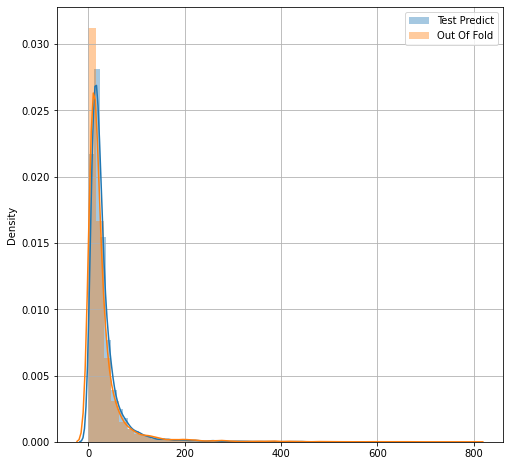

In [54]:
# Submission する前には予測値がまともかどうかちゃんと見ておきます
# https://www.guruguru.science/competitions/13/discussions/41b4ac2d-690b-4ba5-8ff7-be3639578bc1/

Y_test_pred = pd.read_csv("submission_psude.csv").values

path = r"Y_pred_psude.pkl"
#path = r"Y_pred.pkl"
with open(path, "rb") as f:
    Y_oof = pickle.load(f)

fig, ax = plt.subplots(figsize=(8, 8))
sns.distplot(Y_test_pred, label='Test Predict')
sns.distplot(Y_oof.iloc[: train.shape[0]].sum(axis=1), label='Out Of Fold')
ax.legend()
ax.grid()
#plt.xscale('log')